In [1]:
import torch
import torchvision
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from multiprocessing import Process
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from dataloader import create_dataset

In [3]:
def train_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    return decision_tree

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

def prun_and_evaluate(X_train, y_train,X_test, y_test):
    decision_tree = DecisionTreeClassifier()
    path = decision_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # best_alpha = find_best_alpha(X_train, y_train, ccp_alphas)
    best_alpha = 0.0
    pruned_tree = DecisionTreeClassifier( ccp_alpha=best_alpha)
    pruned_tree.fit(X_train, y_train)
    evaluate_model(model, X_train, y_train)
    evaluate_model(pruned_tree, X_test, y_test)

In [4]:
# create dataset
X_train, y_train, X_test, y_test = create_dataset()

In [5]:
# train model
model = train_decision_tree(X_train, y_train)

In [6]:
print("train accuracy")
evaluate_model(model, X_train, y_train)
print("test accuracy")
evaluate_model(model, X_test, y_test)

train accuracy
Accuracy: 100.00%
test accuracy
Accuracy: 87.79%


In [7]:
# calculate cross validation score and alpha and prepare for pruning
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

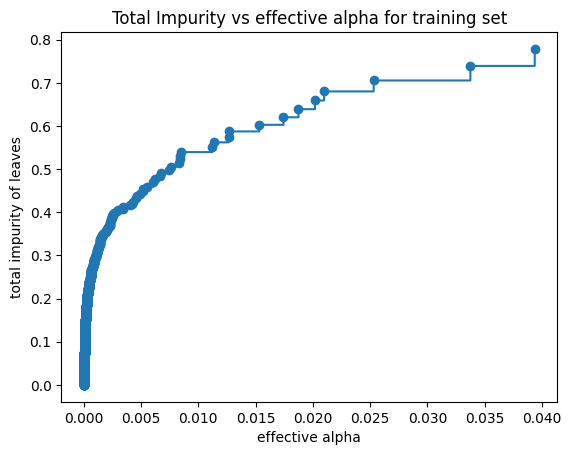

In [8]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [9]:
# To much alpha
new_ccp_alphas = []
print(len(ccp_alphas))
for i, alpha in enumerate(ccp_alphas):
    if alpha > 0.1:
        new_ccp_alphas.append(alpha)
    elif i % 50 == 0:
        new_ccp_alphas.append(alpha)
print(len(new_ccp_alphas))


3167
64


In [10]:
clfs = []
for ccp_alpha in tqdm(new_ccp_alphas, desc="Fitting Decision Trees"):
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Fitting Decision Trees:   0%|          | 0/64 [00:00<?, ?it/s]

Fitting Decision Trees: 100%|██████████| 64/64 [11:03<00:00, 10.37s/it]

Number of nodes in the last tree is: 37 with ccp_alpha: 0.04041109791203201


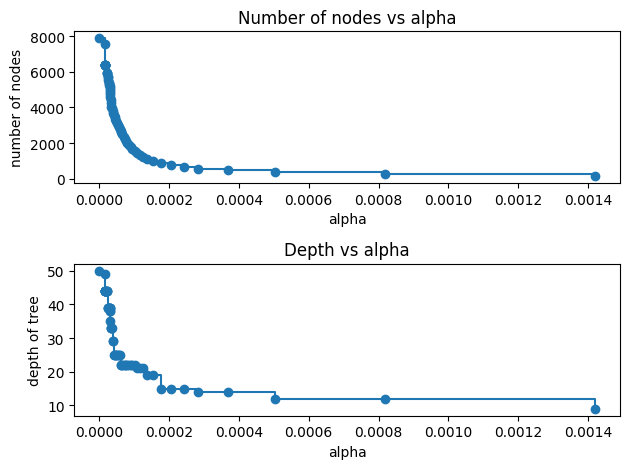

In [11]:
clfs = clfs[:-1]
ccp_alphas = new_ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

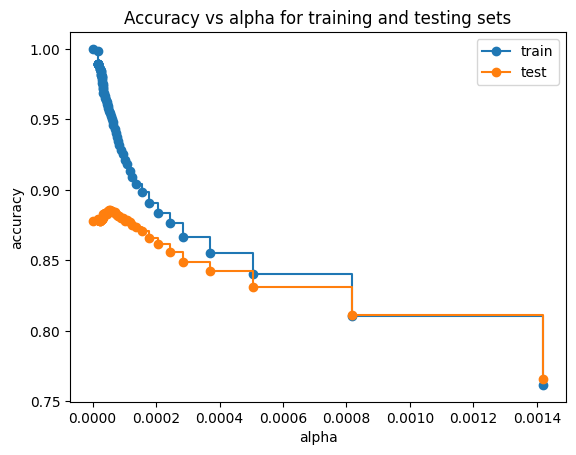

In [12]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()